# Previsão Churn de Clientes de uma Instituição Bancária

Os dados utilizados foram extraídos do seguinte link do Kaggle: https://www.kaggle.com/datasets/shubh0799/churn-modelling

Atributos:

* RowNumber: Número da linha

* CustomerId: ID único do cliente

* Surname: Sobrenome do cliente

* CreditScore: Pontuação de crédito

* Geography: País

* Gender: Gênero

* Age: Idade

* Tenure: Tempo de vínculo com a instituição bancária

* Balance: Saldo da conta

* NumOfProducts: Número de produtos

* HasCrCard: Indica se o cliente possui ou não cartão de crédito

* IsActiveMember: Indica se o cliente é um membro ativo ou não

* EstimatedSalary: Salário estimado

* Exited: Indica se houve ou não churn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTEENN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import pickle

In [2]:
simplefilter("ignore", category=ConvergenceWarning)

## Análise exploratória dos dados

In [3]:
df = pd.read_csv('Churn_Modelling.csv')

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.shape

(10000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
print(f"Total de linhas duplicadas: {df.duplicated().sum()}")

Total de linhas duplicadas: 0


In [7]:
# Excluir colunas
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [8]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


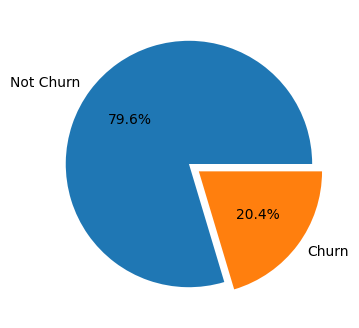

In [9]:
# Distribuição da variável target
plt.figure(figsize=(4, 4))

plt.pie(df['Exited'].value_counts(), labels=['Not Churn', 'Churn'], explode=(0, 0.1), autopct='%1.1f%%')

plt.show()

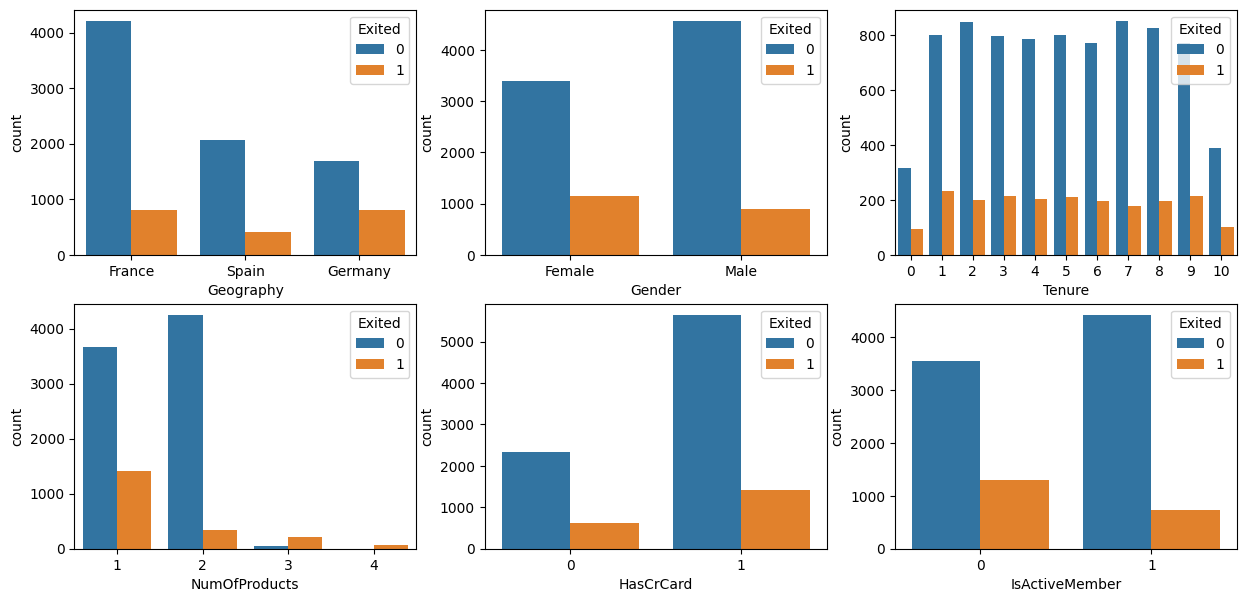

In [10]:
# Distribuição das demais features
fig, ax = plt.subplots(2, 3, figsize = (15, 7))

sns.countplot(df, x='Geography', hue='Exited', ax=ax[0][0])

sns.countplot(df, x='Gender', hue='Exited', ax=ax[0][1])

sns.countplot(df, x='Tenure', hue='Exited', ax=ax[0][2])

sns.countplot(df, x='NumOfProducts', hue='Exited', ax=ax[1][0])

sns.countplot(df, x='HasCrCard', hue='Exited', ax=ax[1][1])

sns.countplot(df, x='IsActiveMember', hue='Exited', ax=ax[1][2])

plt.show()

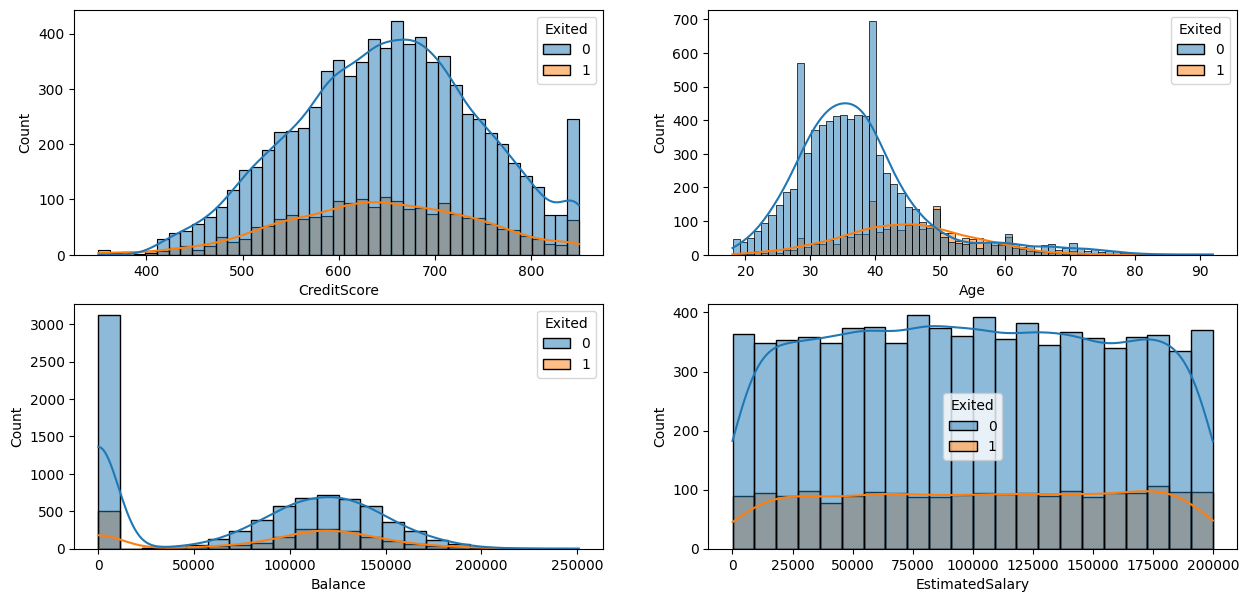

In [11]:
fig, ax = plt.subplots(2, 2, figsize = (15, 7))

sns.histplot(df, x='CreditScore', hue='Exited', kde=True, ax=ax[0][0])

sns.histplot(df, x='Age', hue='Exited', kde=True, ax=ax[0][1])

sns.histplot(df, x='Balance', hue='Exited', kde=True, ax=ax[1][0])

sns.histplot(df, x='EstimatedSalary', hue='Exited', kde=True, ax=ax[1][1])

plt.show()

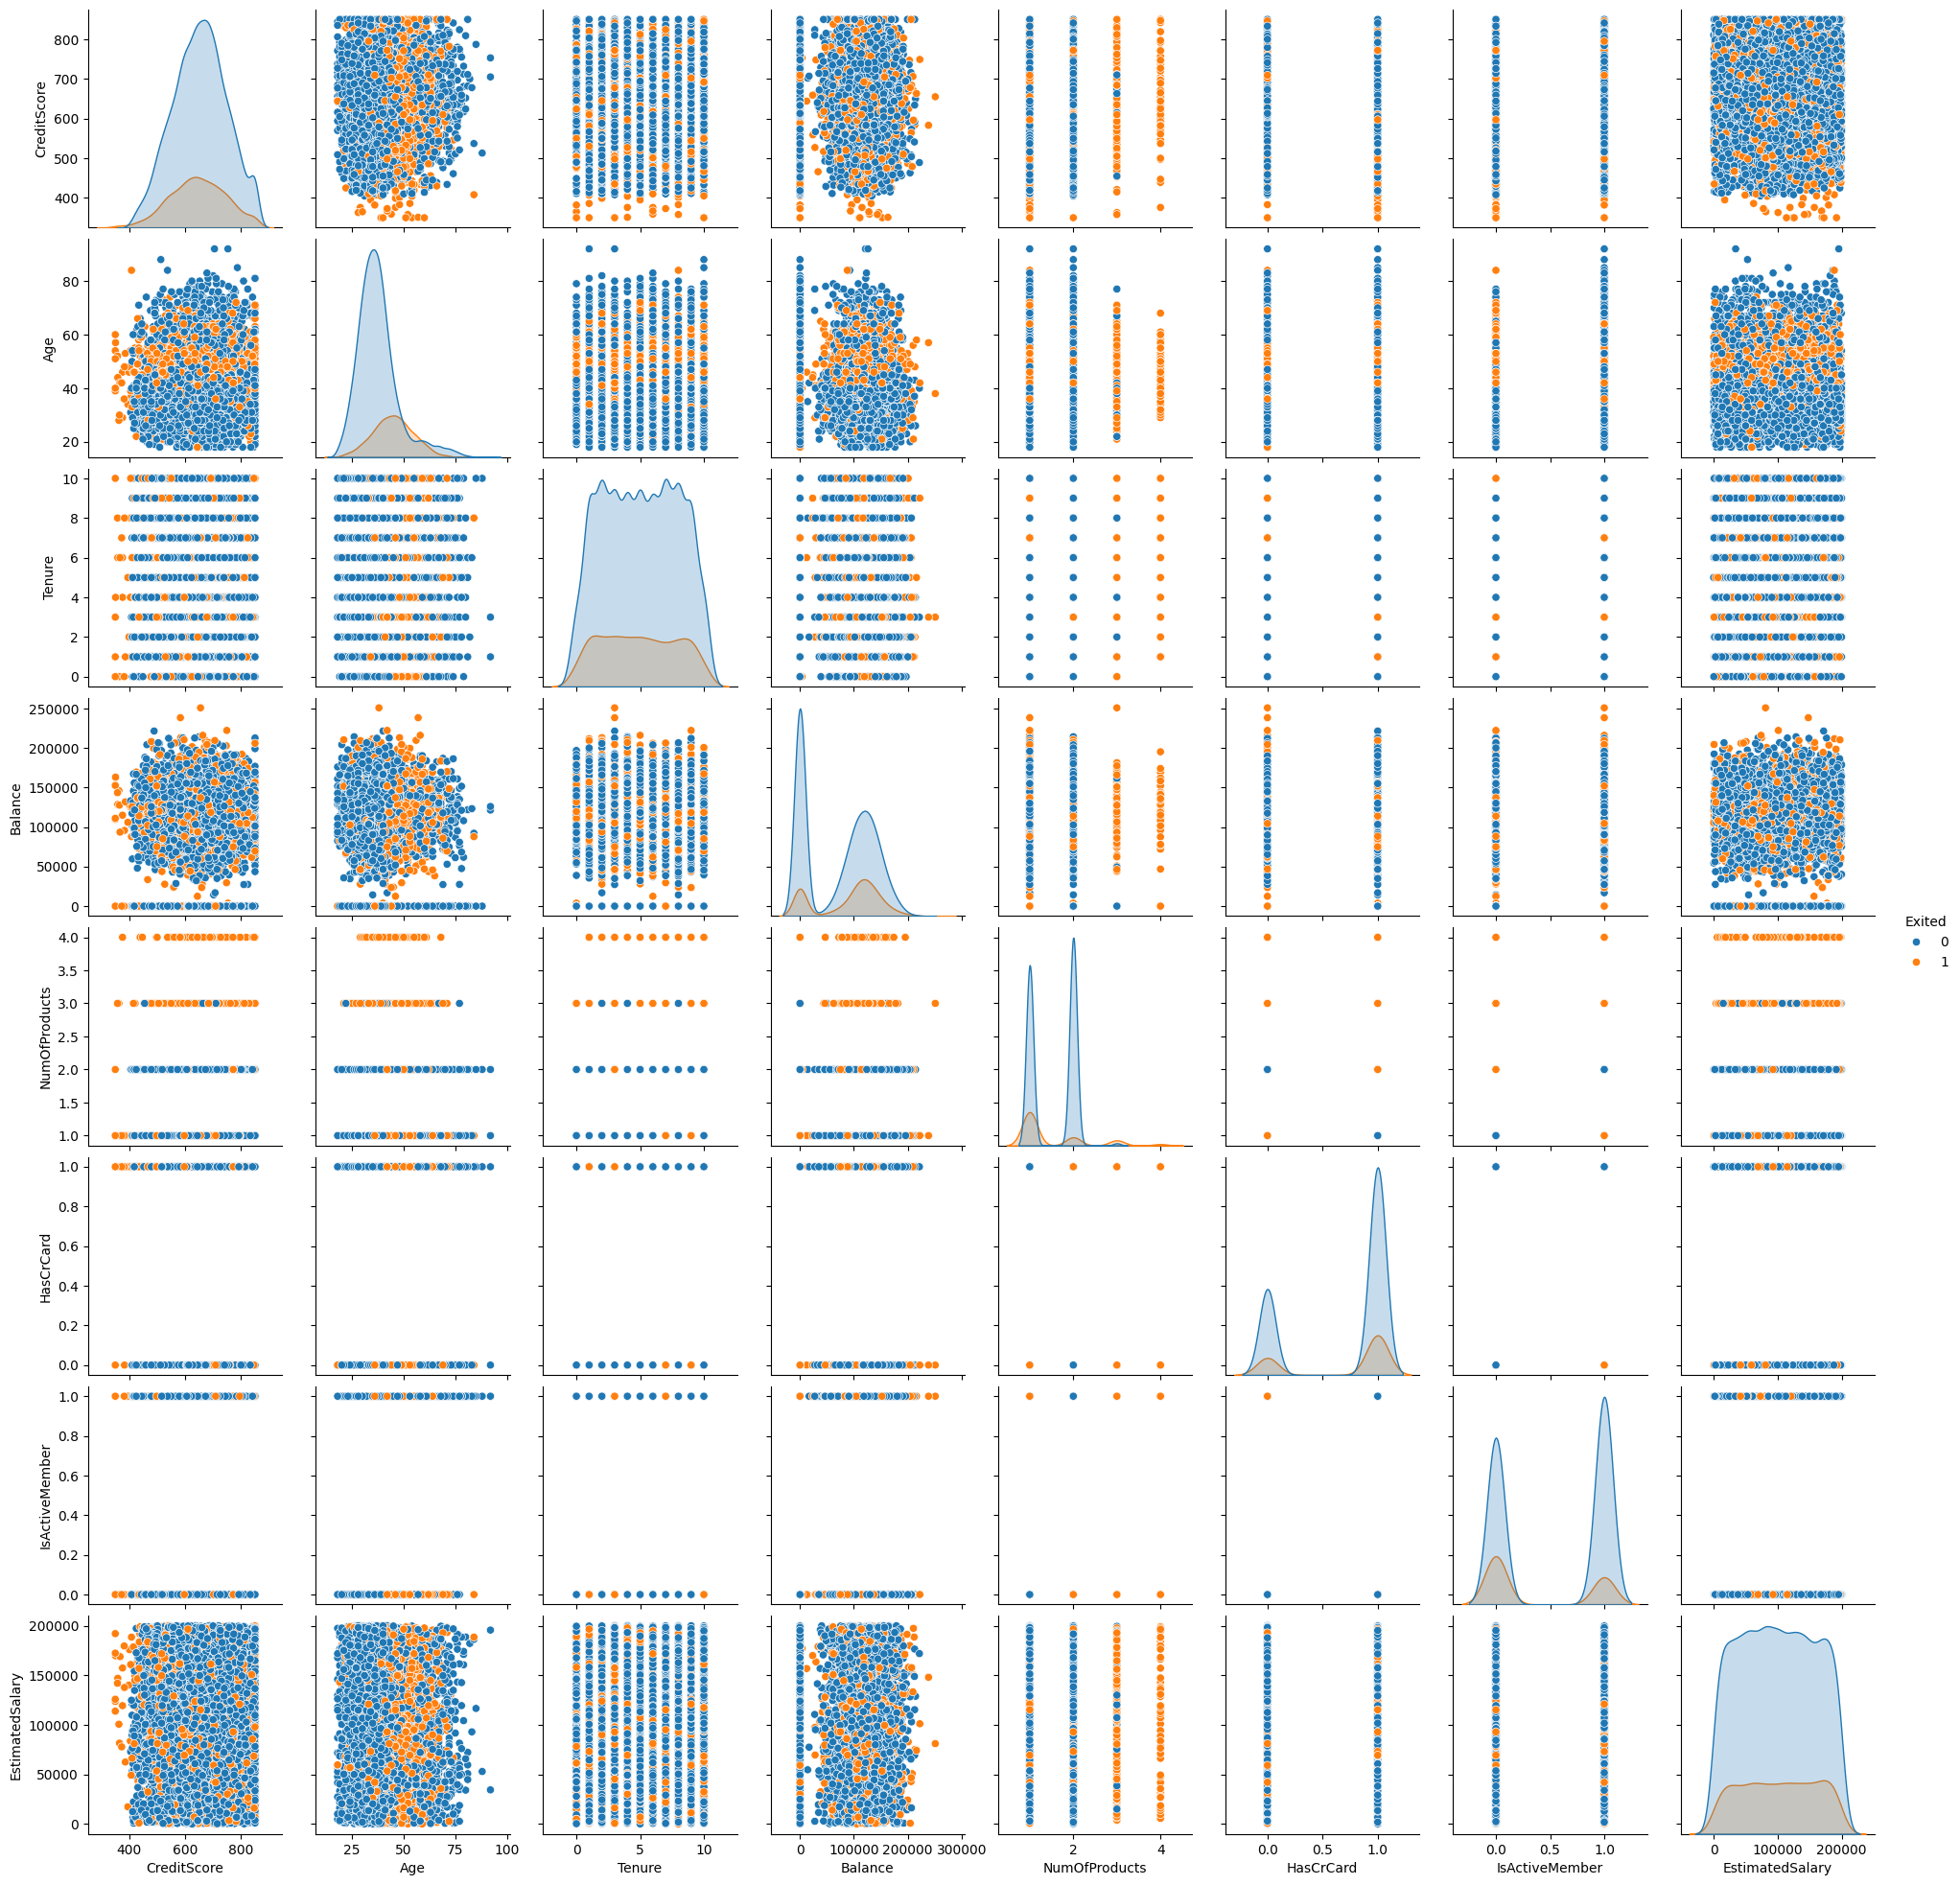

In [12]:
sns.pairplot(df, hue='Exited')

In [13]:
# Transformar variáveis categóricas em numéricas
categorical_cols = ['Geography', 'Gender']

label_encoder = LabelEncoder()

for col in categorical_cols:

    df[col] = label_encoder.fit_transform(df[col])

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


<Axes: >

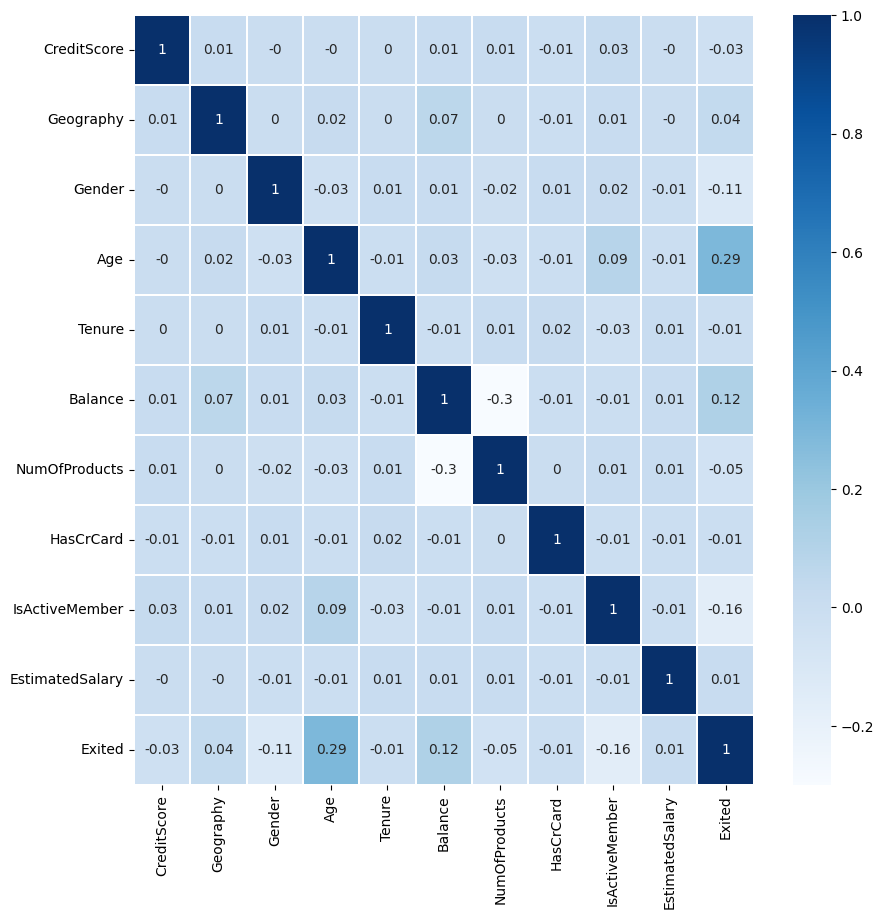

In [14]:
# Matriz de correlação entre as variáveis
plt.figure(figsize=(10, 10))

sns.heatmap(df.corr().round(2), annot=True, linewidths=.3, cmap='Blues')

In [15]:
# Dividir dataset em X (features) e y (target)
X = df.drop('Exited', axis=1)
y = df['Exited']

## Validação de modelos com datatset desbalanceado

In [16]:
# Dividir dados em conjuntos de treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
# Normalizar a escala dos dados
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)

x_test = scaler.fit_transform(x_test)

In [18]:
def model_validation(model, x_train, x_test, y_train, y_test, X, y):

    # Validação cruzada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")

    print(f"Validação cruzada: {scores}")
    print(f"Acurácia média: {scores.mean()}\n")

    # Treinar modelo
    model.fit(x_train, y_train)

    # Testar modelo
    y_pred = model.predict(x_test)

    # Métricas do relatório de classificação
    print(classification_report(y_test, y_pred))

    # Curva ROC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

    roc_auc = metrics.auc(fpr, tpr)

    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

    display.plot()

    plt.show()

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_, normalize='true')

    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    disp.plot();

### LogisticRegression (dataset desbalanceado)

Validação cruzada: [0.793  0.794  0.7925 0.8025 0.793 ]
Acurácia média: 0.7950000000000002

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2003
           1       0.58      0.20      0.29       497

    accuracy                           0.81      2500
   macro avg       0.70      0.58      0.59      2500
weighted avg       0.78      0.81      0.77      2500



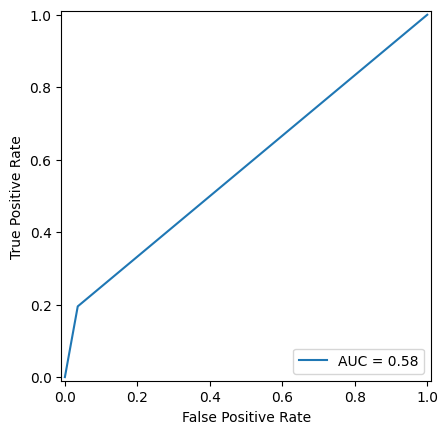

[[0.96455317 0.03544683]
 [0.80482897 0.19517103]]


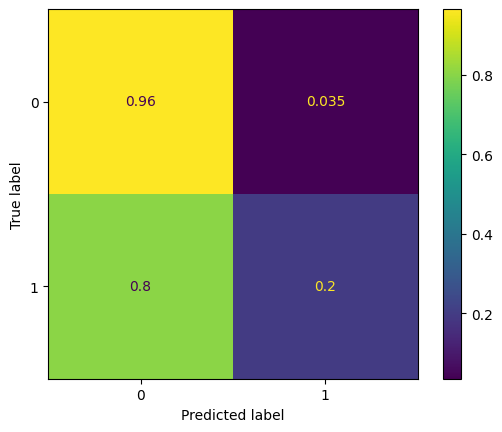

In [19]:
classifier_lr = LogisticRegression()

model_validation(classifier_lr, x_train, x_test, y_train, y_test, X, y)

### KNeighborsClassifier (dataset desbalanceado)

Text(0, 0.5, 'Mean Error')

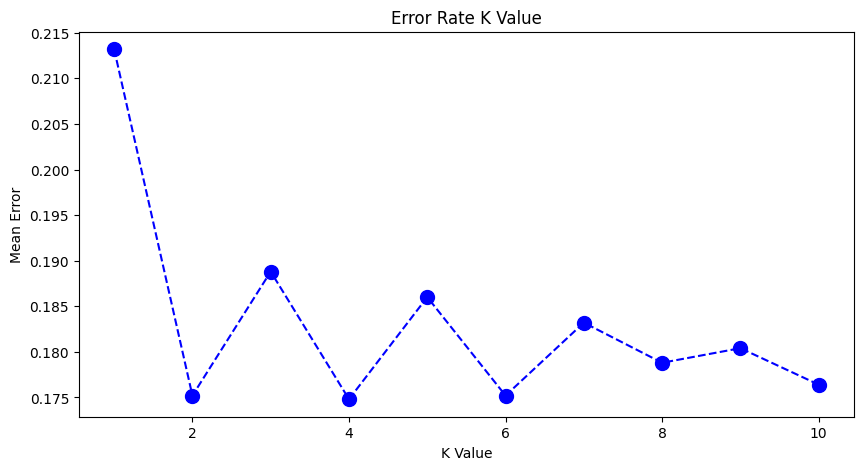

In [20]:
# Cálculo para o melhor valor de k
error_rate =[]

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    pred_k = knn.predict(x_test)
    error_rate.append(np.mean(pred_k != y_test))

plt.figure(figsize=(10, 5))

plt.plot(range(1, 11), error_rate, color="blue", linestyle="dashed", marker="o", markerfacecolor="blue", markersize=10)

plt.title("Error Rate K Value")
plt.xlabel("K Value")
plt.ylabel("Mean Error")

Validação cruzada: [0.768  0.7705 0.7665 0.7695 0.7675]
Acurácia média: 0.7684

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2003
           1       0.67      0.23      0.34       497

    accuracy                           0.82      2500
   macro avg       0.75      0.60      0.62      2500
weighted avg       0.80      0.82      0.79      2500



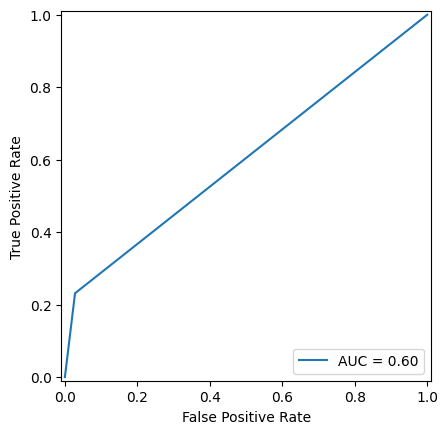

[[0.97204194 0.02795806]
 [0.76861167 0.23138833]]


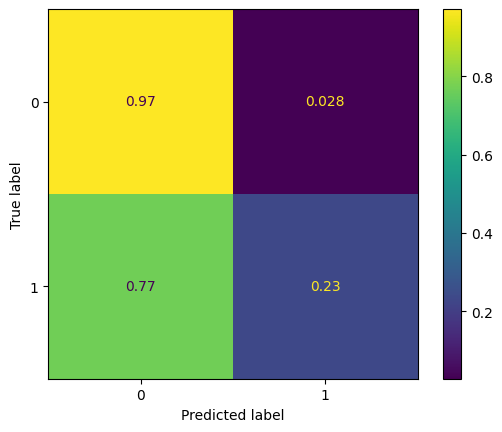

In [21]:
classifier_knn = KNeighborsClassifier(n_neighbors=2)

model_validation(classifier_knn, x_train, x_test, y_train, y_test, X, y)

### DecisionTreeClassifier (dataset desbalanceado)

Validação cruzada: [0.7825 0.791  0.793  0.7875 0.788 ]
Acurácia média: 0.7884

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2003
           1       0.45      0.49      0.47       497

    accuracy                           0.78      2500
   macro avg       0.66      0.67      0.67      2500
weighted avg       0.79      0.78      0.78      2500



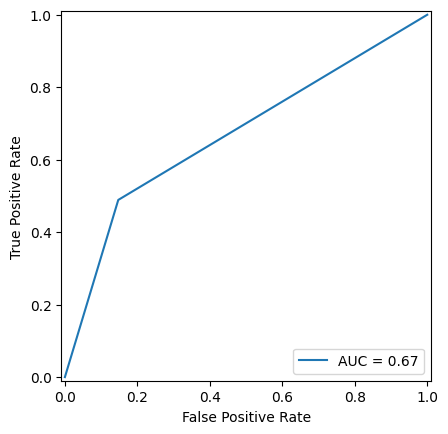

[[0.85272092 0.14727908]
 [0.5110664  0.4889336 ]]


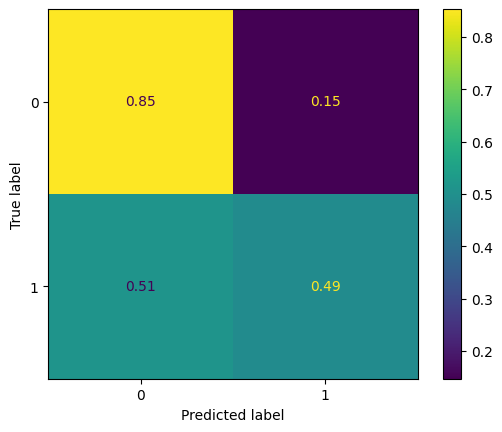

In [22]:
classifier_dt = DecisionTreeClassifier(random_state=42)

model_validation(classifier_dt, x_train, x_test, y_train, y_test, X, y)

### RandomForestClassifier (dataset desbalanceado)

Validação cruzada: [0.8545 0.855  0.859  0.867  0.858 ]
Acurácia média: 0.8587

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2003
           1       0.76      0.44      0.56       497

    accuracy                           0.86      2500
   macro avg       0.82      0.70      0.74      2500
weighted avg       0.85      0.86      0.85      2500



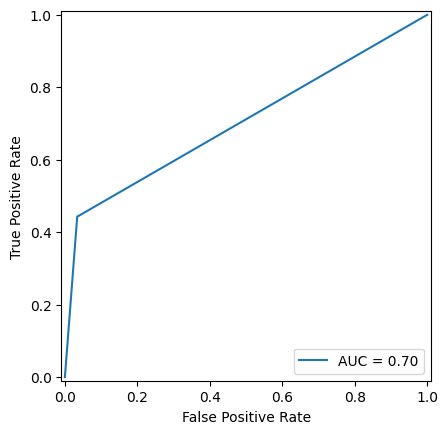

[[0.96605092 0.03394908]
 [0.55734406 0.44265594]]


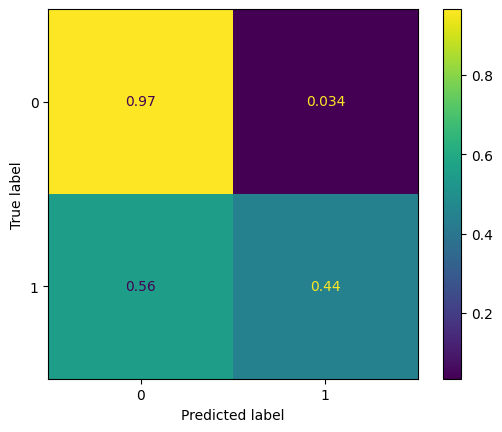

In [23]:
classifier_rf = RandomForestClassifier(random_state=42)

model_validation(classifier_rf, x_train, x_test, y_train, y_test, X, y)

### XGBClassifier (dataset desbalanceado)

Validação cruzada: [0.8475 0.851  0.8585 0.8595 0.8565]
Acurácia média: 0.8546000000000001

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2003
           1       0.69      0.50      0.58       497

    accuracy                           0.86      2500
   macro avg       0.79      0.72      0.75      2500
weighted avg       0.85      0.86      0.85      2500



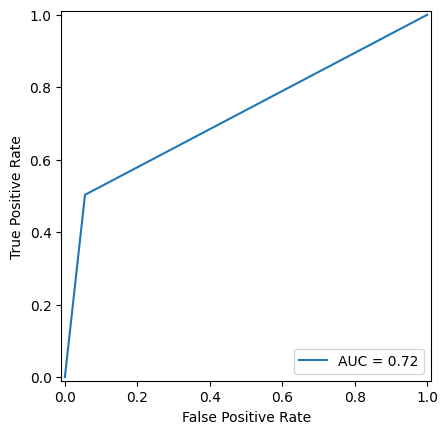

[[0.94458313 0.05541687]
 [0.49698189 0.50301811]]


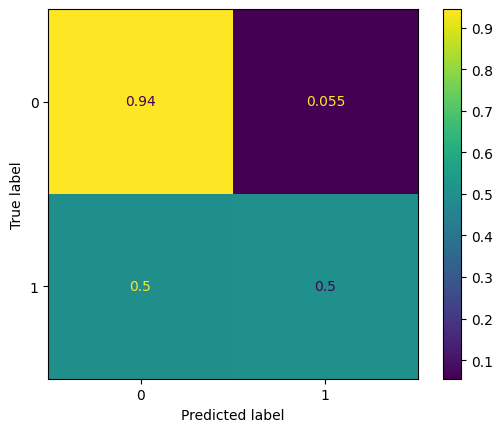

In [24]:
classifier_xgb = XGBClassifier(random_state=42)

model_validation(classifier_xgb, x_train, x_test, y_train, y_test, X, y)

## Validação de modelos com datatset balanceado

In [25]:
# Aplicar sobreamostragem nos dados
smoteenn = SMOTEENN(sampling_strategy='minority', random_state=42)

X_balanced, y_balanced = smoteenn.fit_resample(X, y)

In [26]:
# Dividir dados em conjuntos de treino e teste
x_train, x_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.25, random_state=42)

In [27]:
# Normalizar a escala dos dados
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)

x_test = scaler.fit_transform(x_test)

### LogisticRegression (dataset balanceado)

Validação cruzada: [0.71212121 0.70378788 0.71590909 0.70757576 0.70432146]
Acurácia média: 0.7087430790084316

              precision    recall  f1-score   support

           0       0.81      0.68      0.74       740
           1       0.77      0.87      0.81       910

    accuracy                           0.78      1650
   macro avg       0.79      0.77      0.78      1650
weighted avg       0.79      0.78      0.78      1650



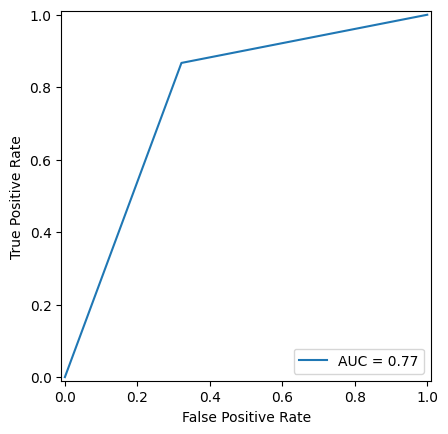

[[0.67837838 0.32162162]
 [0.13296703 0.86703297]]


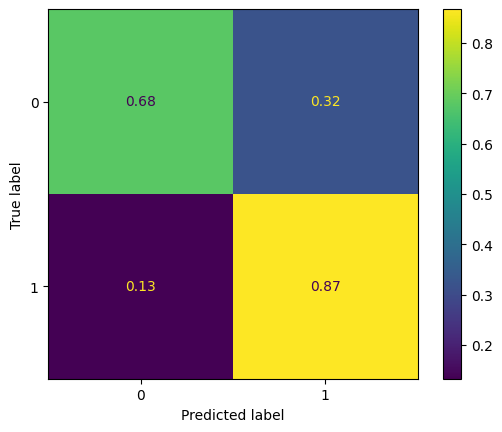

In [28]:
classifier_lr = LogisticRegression()

model_validation(classifier_lr, x_train, x_test, y_train, y_test, X_balanced, y_balanced)

### KNeighborsClassifier (dataset balanceado)

Text(0, 0.5, 'Mean Error')

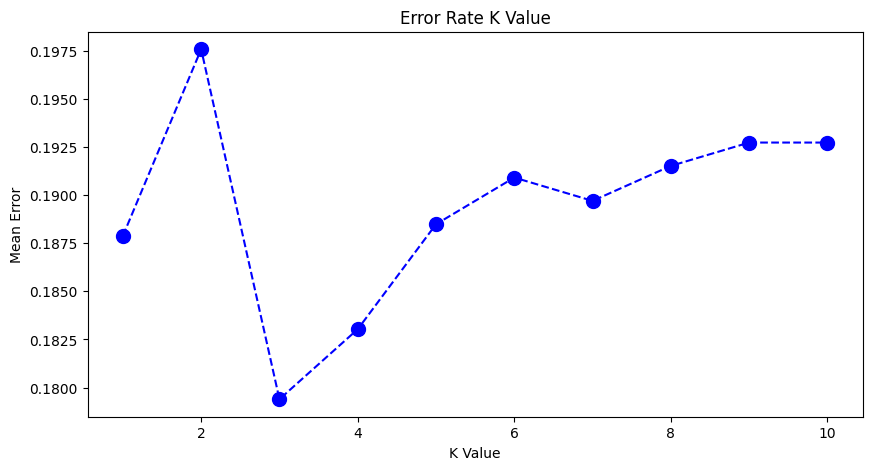

In [29]:
# Cálculo para o melhor valor de k
error_rate =[]

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    pred_k = knn.predict(x_test)
    error_rate.append(np.mean(pred_k != y_test))

plt.figure(figsize=(10, 5))

plt.plot(range(1, 11), error_rate, color="blue", linestyle="dashed", marker="o", markerfacecolor="blue", markersize=10)

plt.title("Error Rate K Value")
plt.xlabel("K Value")
plt.ylabel("Mean Error")

Validação cruzada: [0.94015152 0.92575758 0.925      0.93636364 0.92039424]
Acurácia média: 0.9295333930663727

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       740
           1       0.82      0.86      0.84       910

    accuracy                           0.82      1650
   macro avg       0.82      0.82      0.82      1650
weighted avg       0.82      0.82      0.82      1650



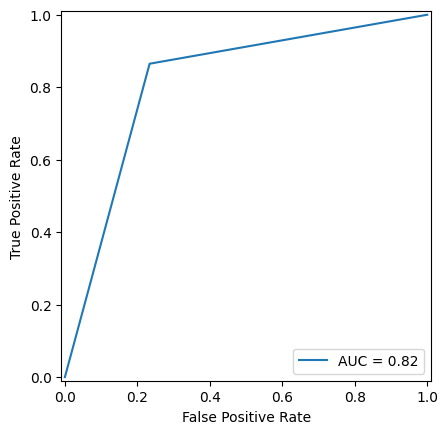

[[0.76621622 0.23378378]
 [0.13516484 0.86483516]]


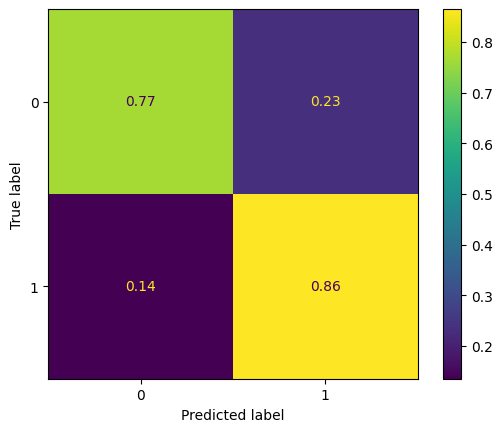

In [30]:
classifier_knn = KNeighborsClassifier(n_neighbors=3)

model_validation(classifier_knn, x_train, x_test, y_train, y_test, X_balanced, y_balanced)

### DecisionTreeClassifier (dataset balanceado)

Validação cruzada: [0.81666667 0.80530303 0.82348485 0.83257576 0.80515542]
Acurácia média: 0.8166371447607232

              precision    recall  f1-score   support

           0       0.79      0.74      0.77       740
           1       0.80      0.84      0.82       910

    accuracy                           0.80      1650
   macro avg       0.79      0.79      0.79      1650
weighted avg       0.80      0.80      0.80      1650



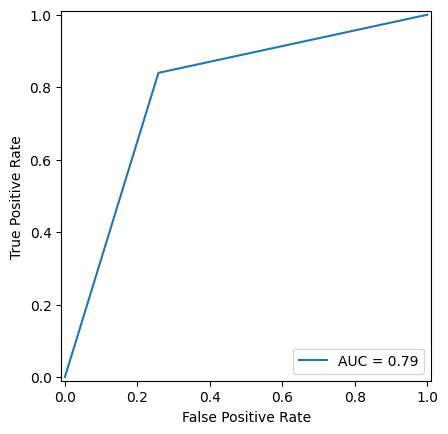

[[0.74189189 0.25810811]
 [0.16043956 0.83956044]]


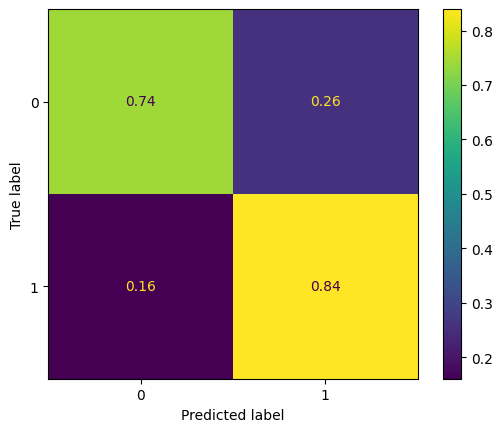

In [31]:
classifier_dt = DecisionTreeClassifier(random_state=42)

model_validation(classifier_dt, x_train, x_test, y_train, y_test, X_balanced, y_balanced)

### RandomForestClassifier (dataset balanceado)

Validação cruzada: [0.87727273 0.86287879 0.87878788 0.87045455 0.87035633]
Acurácia média: 0.8719500539894778

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       740
           1       0.85      0.91      0.88       910

    accuracy                           0.86      1650
   macro avg       0.86      0.86      0.86      1650
weighted avg       0.86      0.86      0.86      1650



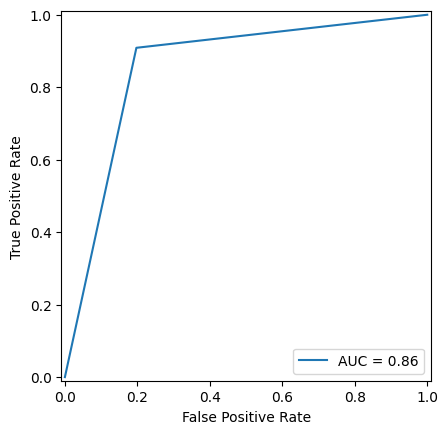

[[0.8027027  0.1972973 ]
 [0.09120879 0.90879121]]


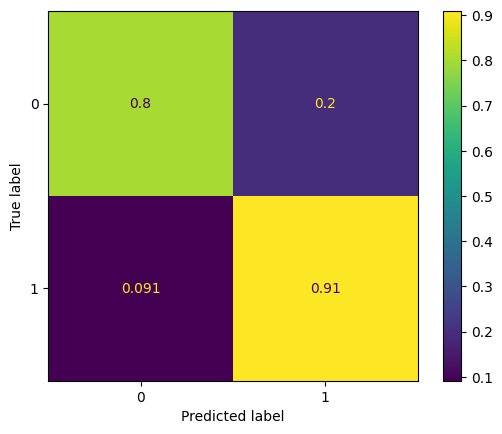

In [32]:
classifier_rf = RandomForestClassifier(random_state=42)

model_validation(classifier_rf, x_train, x_test, y_train, y_test, X_balanced, y_balanced)

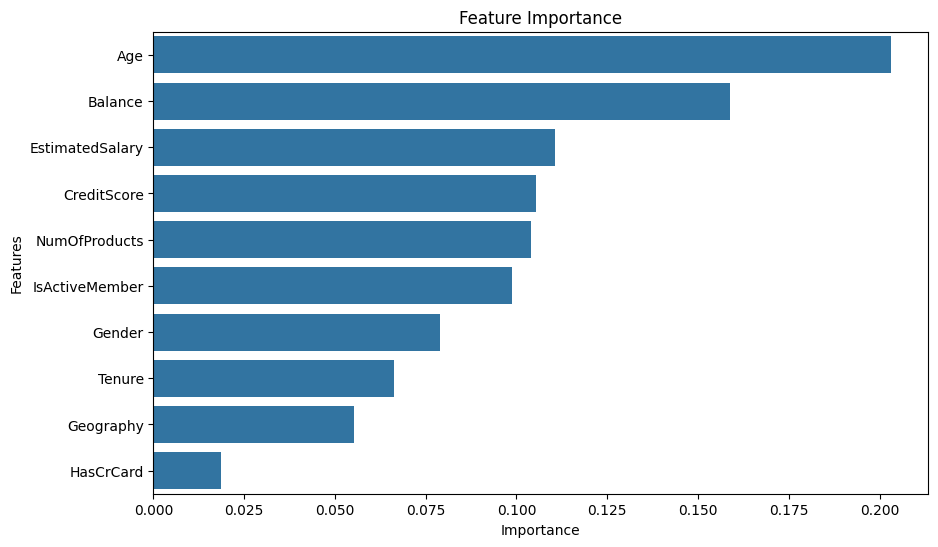

In [33]:
# Visualizar a contribuição de cada variável na análise preditiva do modelo
importances = classifier_rf.feature_importances_

features = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

df_feature_importance = pd.DataFrame({'feature': features, 'importance': importances})

df_feature_importance = df_feature_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=df_feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

### XGBClassifier (dataset balanceado)

Validação cruzada: [0.90833333 0.88787879 0.88409091 0.87954545 0.88703563]
Acurácia média: 0.889376823580766

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       740
           1       0.87      0.90      0.88       910

    accuracy                           0.87      1650
   macro avg       0.87      0.87      0.87      1650
weighted avg       0.87      0.87      0.87      1650



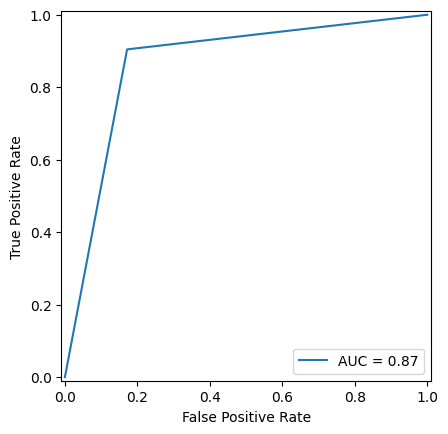

[[0.82837838 0.17162162]
 [0.0956044  0.9043956 ]]


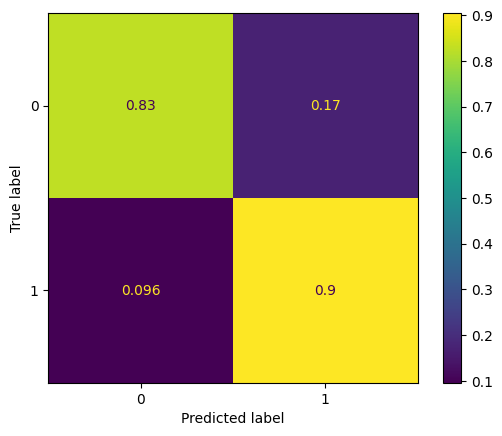

In [34]:
classifier_xgb = XGBClassifier(random_state=42)

model_validation(classifier_xgb, x_train, x_test, y_train, y_test, X_balanced, y_balanced)

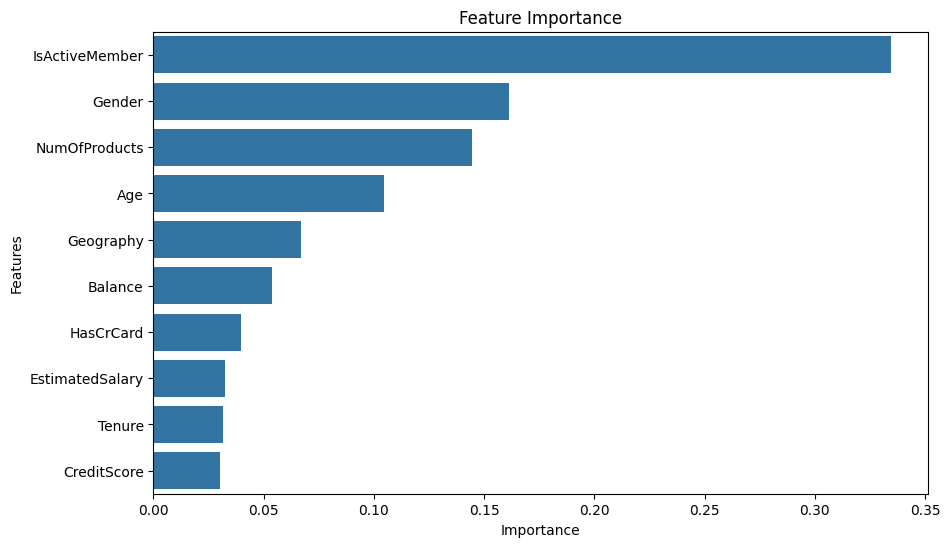

In [35]:
# Visualizar a contribuição de cada variável na análise preditiva do modelo
importances = classifier_xgb.feature_importances_

features = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

df_feature_importance = pd.DataFrame({'feature': features, 'importance': importances})

df_feature_importance = df_feature_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=df_feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Salvar o modelo

In [36]:
filename = 'modelo_churn.pkl'
pickle.dump(classifier_xgb, open(filename, 'wb'))